# Causal analysis of time-series events with causaltestdata

In [1]:
import datetime
import networkx as nx
from IPython.display import SVG, display

import causaltestdata.variable
import causaltestdata.tool

## Input graph structure and generated data

The potential causal structure (usually used as ground truth) is specified in networkx.DiGraph format. Note that the graph structure should be DAG.

Defaults indicates the optional settings to determine the behavior of generated data. 
- "default_type": "tsevent" if you intend to generate TimeSeriesEvent.
- "tsevent_lambd": A parameter of event appearance frequency. 10 in default, which means 10 times per day in average.
- "dt_range": Time-series range. 1 day in default.
- "dt_interval": Time bin size to generate the data. 1 minute in default, where a value 2 means the event appear twice in a 1 minute bin.  

In [15]:
g = nx.DiGraph()
g.add_nodes_from([1, 2, 3])
g.add_edge(3, 1, weight=0.7)
g.add_edge(3, 2, weight=0.5)
defaults = {"default_type": "tsevent",
            "tsevent_lambd": 100,  # 10 in default
            "dt_range": (datetime.datetime(2112, 9, 3), datetime.datetime(2112, 9, 4))  # same as default
            "dt_interval": datetime.timedelta(minutes=1)}  # same as default
assert nx.is_directed_acyclic_graph(g)
df = causaltestdata.variable.generate_all(g, defaults)

- Visualization of the given potential causal structure

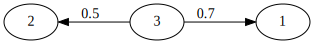

In [16]:
graph = causaltestdata.tool.visual_model(g, defaults)
svg = SVG(nx.nx_agraph.to_agraph(graph).draw(prog='circo', format='svg'))
display(svg)

- Generated time-series data that follows the given causal structure

In [17]:
df

,1,2,3
2112-09-03 00:00:00,0,0,0
2112-09-03 00:01:00,0,0,0
2112-09-03 00:02:00,1,0,1
2112-09-03 00:03:00,0,0,0
2112-09-03 00:04:00,1,0,1
...,...,...,...
2112-09-03 23:55:00,0,0,0
2112-09-03 23:56:00,0,1,1
2112-09-03 23:57:00,0,1,0
2112-09-03 23:58:00,0,1,0


## Regression

The regression coefficient of node 1 with node 2 is large enough to be considered as correlation.

In [18]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
X = df.loc[:, [1]]
Y = df[2]
clf.fit(X, Y)
print(clf.coef_[0])

0.22373628254219624


The partial regression coefficient of node 1 with node 2, considering node 3 as another explanation variable, is much smaller than the standard regression coefficient. It means there is a spurious correlation.

In [19]:
clf = linear_model.LinearRegression()
X = df.loc[:, [1, 3]]
Y = df[2]
clf.fit(X, Y)
print(clf.coef_[0])

0.017386287126330495


## PC algorithm

Here we use the stable-PC algorithm with G square test as the conditional independence test.

Python package "pcalg" is available in PyPI. See also https://github.com/keiichishima/pcalg.

G square test requires binary input, so we binarize the input in advance.

In [22]:
import pcalg
from gsq.ci_tests import ci_test_bin
columns = df.columns
pc_data_matrix = df.apply(lambda s: s.map(lambda x: 1 if x >= 1 else 0))
args = {"indep_test_func": ci_test_bin,
        "data_matrix": pc_data_matrix.values,
        "alpha": 0.01,
        "method": "stable"}
graph, sep_set = pcalg.estimate_skeleton(**args)
graph = pcalg.estimate_cpdag(skel_graph=graph, sep_set=sep_set)
graph = nx.relabel_nodes(graph, mapping={node: columns[node] for node in graph.nodes()})

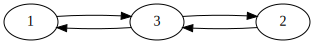

In [23]:
svg = SVG(nx.nx_agraph.to_agraph(graph).draw(prog='circo', format='svg'))
display(svg)

## LiNGAM

Here we demonstrate causal discovery with DirectLiNGAM.

Python package "lingam" is available in PyPI. See also https://github.com/cdt15/lingam.

In [38]:
import numpy as np
import lingam

lower_limit = 0.01

model = lingam.DirectLiNGAM()
model.fit(df)
adj = np.nan_to_num(model.adjacency_matrix_)

g = nx.DiGraph()
for i in range(adj.shape[0]):
    g.add_node(df.columns[i])

idx = np.abs(adj) > lower_limit
dirs = np.where(idx)
for to_idx, from_idx, coef in zip(dirs[0], dirs[1], adj[idx]):
    to = df.columns[to_idx]
    from_ = df.columns[from_idx]
    g.add_edge(from_, to, weight=coef, label=str(round(coef, 2)))

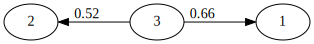

In [39]:
svg = SVG(nx.nx_agraph.to_agraph(g).draw(prog='circo', format='svg'))
display(svg)